In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from hackerStats import dcst # Custom written hacker statistics functions

In [2]:
sns.set()

## Graphical EDA of men's 200 free heats
Plotting an ECDF of the men's 200 freestyle, to explore how the swim times are distributed.<br>
fast swimmers are below 115 seconds, with a smattering of slow swimmers past that.

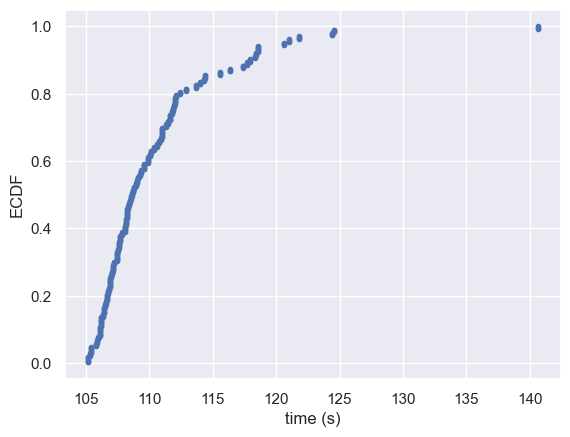

In [3]:
# Load and prepare data
df = pd.read_csv('datasets/2015_FINA.csv', skiprows=4).dropna()
mens_200_free_heats = df.loc[
    (df['distance'] == 200) &
    (df['gender'] == 'M') &
    (df['stroke'] == 'FREE'), 'swimtime'].to_numpy()
# Generate x and y values for ECDF: x, y
x, y = dcst.ecdf(mens_200_free_heats)

# Plot the ECDF as dots
plt.plot(x, y, marker='.', linestyle='none')

# Label axes and show plot
plt.xlabel('time (s)')
plt.ylabel('ECDF')
plt.show()

## 200 m free time with confidence interval

The median is useful because it is immune to heavy tails in the distribution of swim times, such as the slow swimmers in the heats.

In [4]:
# Compute mean and median swim times
mean_time = np.mean(mens_200_free_heats)
median_time = np.median(mens_200_free_heats)

# Draw 10,000 bootstrap replicates of the mean and median
bs_reps_mean = dcst.draw_bs_reps(mens_200_free_heats, np.mean, 10 ** 4)
bs_reps_median = dcst.draw_bs_reps(mens_200_free_heats, np.median, 10 ** 4)


# Compute the 95% confidence intervals
conf_int_mean = np.percentile(bs_reps_mean, [2.5, 97.5])
conf_int_median = np.percentile(bs_reps_median, [2.5, 97.5])

# Print the result to the screen
print("""
mean time: {0:.2f} sec.
95% conf int of mean: [{1:.2f}, {2:.2f}] sec.

median time: {3:.2f} sec.
95% conf int of median: [{4:.2f}, {5:.2f}] sec.
""".format(mean_time, *conf_int_mean, median_time, *conf_int_median))


mean time: 110.43 sec.
95% conf int of mean: [109.94, 110.96] sec.

median time: 108.67 sec.
95% conf int of median: [108.27, 109.09] sec.



## EDA: Do swimmers go faster in the finals?
To answer this question, the average swim time of finals shouldn't be compared to the average swim time of the semi finals, because only the best swimmers get to compete in the finals, so it is expected that the average of finals will be larger.<br>

A better approach would be to compare swim times for individual swimmers. Specifically, between finals and semifinals, as most swimmers don't give their best during the heats rounds to prevent early exhaustion.<br>

Each type of stroke belongs to a different distribution (different mean, and variance) as some are swam faster than others, so they should not be averaged out.

The analysis will consider:<br>
* female swimmers
* 50, 100, 200 meters
* Strokes that have semifinals: butterfly, breaststroke, backstroke & freestyle.

First, understand how athletes' performance changes from the semifinals to the finals by computing the fractional improvement from the semifinals to finals and plotting an ECDF of all of these values.<br>
At first glance, it does not look like there is much of any difference between semifinals and finals. 

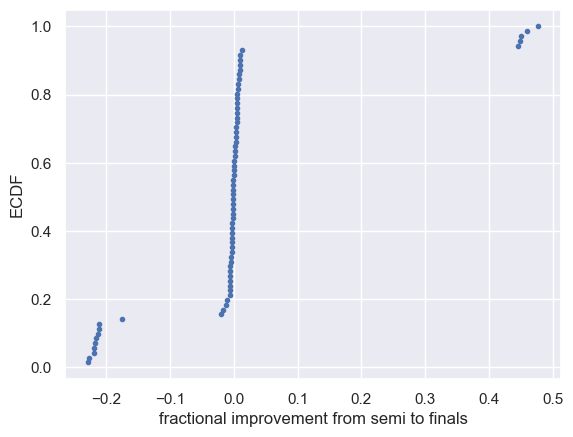

In [5]:
top_athletes = df.loc[df['round'] == 'FIN', 'athleteid'].unique() # Athletes who made it to finals
df_female = df[
    (df['athleteid'].isin(top_athletes)) &
    (df['gender'] == 'F') & 
    (df['round'].isin(['FIN', 'SEM'])) &
    (df['distance'].isin([50, 100, 200])) &
    (df['stroke'].isin(['FREE', 'FLY', 'BREAST', 'BACK']))]

# Pivot table with round swim times as different columns, for each athlete for each stroke
df_female = pd.pivot_table(df_female[['athleteid', 'round', 'swimtime', 'stroke']], 
                           values='swimtime', columns='round', index=['athleteid', 'stroke'], aggfunc=np.mean)

df_female.dropna(inplace=True)

semi_times= df_female['SEM'].to_numpy()
final_times = df_female['FIN'].to_numpy()

# Compute fractional difference in time between finals and semis
f = (semi_times - final_times) / semi_times

# Generate x and y values for the ECDF: x, y
x, y = dcst.ecdf(f)

# Make a plot of the ECDF
plt.plot(x, y, marker='.', linestyle='none')

# Label axes and show plot
_ = plt.xlabel('fractional improvement from semi to finals')
_ = plt.ylabel('ECDF')
plt.show()

## Permutation test

Generate permutation samples to test the *null-hypohesis*:  ```semi_times``` and  ```final_times``` come from the same distribution.<br>

The p-value is large, about 0.21, which suggests that the results of the 2015 World Championships are consistent with there being no difference in performance between the finals and semifinals.

In [6]:
# Set up array of permutation replicates
perm_reps = np.empty(1000)

f_mean = np.mean(f)

for i in range(1000):
    # Generate a permutation sample
    semi_perm, final_perm = dcst.swap_random(semi_times, final_times)
    
    # Compute f from the permutation sample
    f = (semi_perm - final_perm) / semi_perm
    
    # Compute and store permutation replicate
    perm_reps[i] = np.mean(f)

# Compute and print p-value
print('p =', np.sum(perm_reps >= f_mean) / 1000)

p = 0.203


## How does the performance of swimmers decline over long events? (EDA)
**Terminology:**<br>
*Split:* The time it takes for the swimmer to swim one length of the pool (50 meters).<br>

The performance of the first two splits is very high as the swimmer gets a boost at the start of the race. For the last two splits the time taken is also less, because the swimmer pushes himself hard to win the race. Therefore, they will not be taken into consideration, as they don't give insight into how swimmers generally fatigue during the race.<br>

**Quantifying slowdown:**<br>
* Use women's 800 meters freestyle heats
* Omit the first and last 100 meters in each split as they vary between each swimmer.<br>
* Compute the mean split for each split number<br>
* Perform linear regression to get slowdown per split
* Hypothesis test: Can the slowdown be explained by random variation?

From the plot below, a wide variation appears between the splits of various swimmers. The mean line suggests that there is a general increase in split over the race.

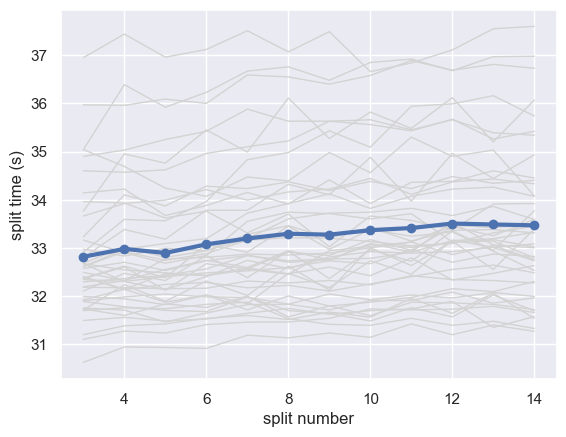

In [7]:
# Prepare data for splits
df_splits = df[
    (df['distance'] == 800) &
    (df['gender'] == "F") &
    (df['stroke'] == "FREE")][['splitswimtime', 'athleteid', 'split']]

# splits[i][j] where i is a swimmer, and j is the split for split number j
splits = pd.pivot_table(df_splits, columns='split', values='splitswimtime', index='athleteid', aggfunc=np.mean).dropna()
splits = splits.iloc[:, 2:-2] # Omit the first and last 2 splits
split_number = splits.columns.to_numpy()
# Plot the splits for each swimmer
for idx, splitset in splits.iterrows():
    _ = plt.plot(split_number, splitset, linewidth=1, color='lightgray')

# Compute the mean split times
mean_splits = splits.mean(axis=0).to_numpy()

# Plot the mean split times
plt.plot(split_number, mean_splits, marker='.', linewidth=3, markersize=12)

# Label axes and show plot
_ = plt.xlabel('split number')
_ = plt.ylabel('split time (s)')
plt.show()

## Slowdown rate using linear regression

Assuming that the swimmers slowdown in a linear fashion as suggested by the plot above, the slope of the linear regression line is the slowdown rate.<br>

Slope of the best fit lies within the 95% conf. interval of a pairs bootstrap test, the slowdown, however, is very subtle. A correlation test will be done next. 

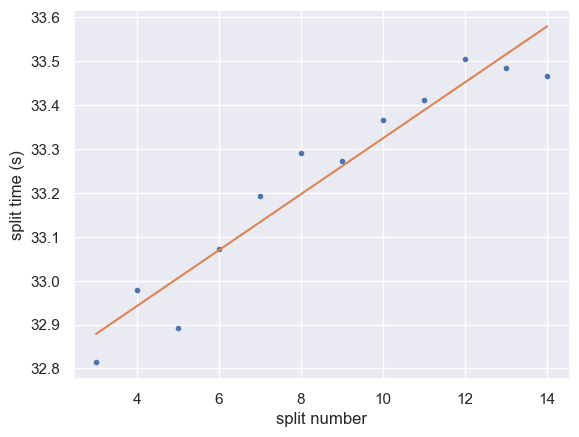


mean slowdown: 0.064 sec./split
95% conf int of mean slowdown: [0.049, 0.078] sec./split


In [8]:
# Perform regression
slowdown, split_3 = np.polyfit(split_number, mean_splits, deg=1)

# Compute pairs bootstrap
bs_reps, _ = dcst.draw_bs_pairs_linreg(split_number, mean_splits, 10 ** 4)

# Compute confidence interval
conf_int = np.percentile(bs_reps, [2.5, 97.5])

# Plot the data with regressions line
_ = plt.plot(split_number, mean_splits, marker='.', linestyle='none')
_ = plt.plot(split_number, slowdown * split_number + split_3, '-')

# Label axes and show plot
_ = plt.xlabel('split number')
_ = plt.ylabel('split time (s)')
plt.show()

# Print the slowdown per split
print("""
mean slowdown: {0:.3f} sec./split
95% conf int of mean slowdown: [{1:.3f}, {2:.3f}] sec./split""".format(
    slowdown, *conf_int))

# Hypothesis test: are they slowing down?
Test the null hypothesis that the swimmer's split time is not at all correlated with the distance they are at in the swim, using pearson correlation.<br>

With 10,000 replicates, we never got a correlation as big as observed under the hypothesis that the swimmers do not change speed as the race progresses, suggesting that the correlation, does indeed exist.

In [9]:
# Observed correlation
rho = dcst.pearson_r(split_number, mean_splits)

# Initialize permutation reps
perm_reps_rho = np.empty(10 ** 4)

# Make permutation reps
for i in range(10000):
    # Scramble the split number array
    scrambled_split_number = np.random.permutation(split_number)
    
    # Compute the Pearson correlation coefficient
    perm_reps_rho[i] = dcst.pearson_r(scrambled_split_number, mean_splits)
    
# Compute and print p-value
p_val = np.sum(perm_reps_rho >= rho) / len(perm_reps_rho)
print('p =', p_val)

p = 0.0
